In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import regionmask
import shapely

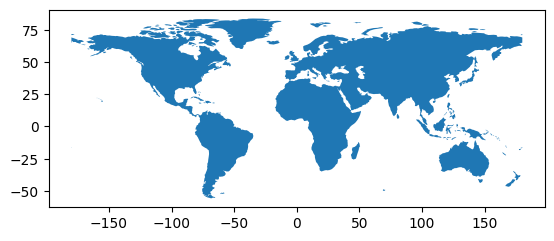

In [26]:
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
gdf_land = gpd.GeoSeries(land.polygons, crs="EPSG:4326")

# remove antarctic
geom = gdf_land.geometry.iloc[0]
polygons = list(geom.geoms)
polygons_no_antarctica = [
    p for p in polygons
    if p.bounds[3] > -60
]
gdf_land.geometry.iloc[0] = shapely.MultiPolygon(polygons_no_antarctica)

gdf_land_meters = gdf_land.to_crs(epsg=3395)
gdf_land.plot()
plt.show()

In [6]:
from pyproj import CRS

aeqd_na = CRS.from_proj4(
    "+proj=aeqd "
    "+lat_0=90 "
    "+lon_0=0 "
    "+x_0=0 "
    "+y_0=0 "
    "+datum=WGS84 "
    "+units=m "
    "+no_defs"
)

In [7]:
gdf_land_aeqd = gdf_land.to_crs(aeqd_na)

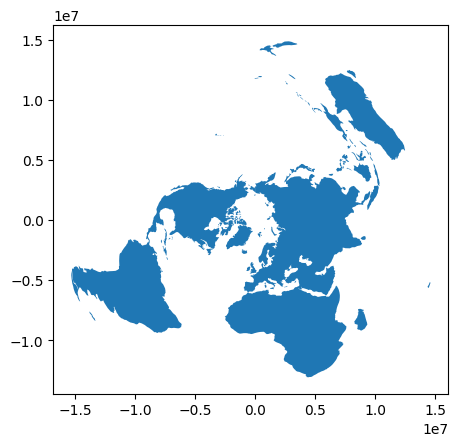

In [27]:
gdf_land_aeqd.plot()
plt.show()

In [28]:
margin_distance = 300000
buffered = gdf_land_aeqd.buffer(margin_distance)
rough_polygon = buffered.simplify(tolerance=200000, preserve_topology=True)
final_polygon = rough_polygon.buffer(0)

In [29]:
from shapely.geometry import box
world = box(-1.6e7, -1.6e7, 1.6e7, 1.6e7)

# thats for flat
#final_polygon = final_polygon.intersection(world)

In [35]:
def safe_union(geoms):
    fixed = geoms.apply(lambda g: shapely.make_valid(g) if not g.is_valid else g)
    fixed = fixed[~fixed.is_empty & fixed.notnull()]
    return shapely.ops.unary_union(fixed.values)


land_shape = safe_union(final_polygon.geometry)
ocean_polygon = world.difference(land_shape)
gdf_ocean = gpd.GeoDataFrame(geometry=[ocean_polygon])

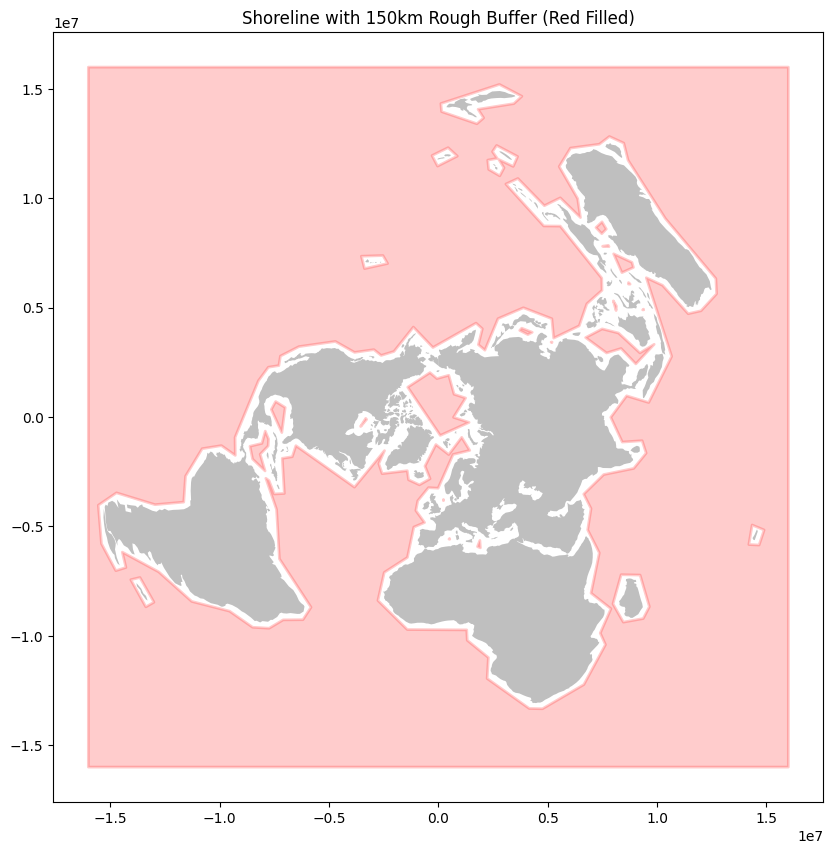

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
gdf_ocean.plot(ax=ax,
                   edgecolor='red',
                   facecolor='red',
                   alpha=0.2,
                   linewidth=2,
                   label='Rough Margin')
gdf_land_aeqd.plot(ax=ax, color='gray', alpha=0.5, label='Original Land')

ax.set_title("Shoreline with 150km Rough Buffer (Red Filled)")
plt.show()

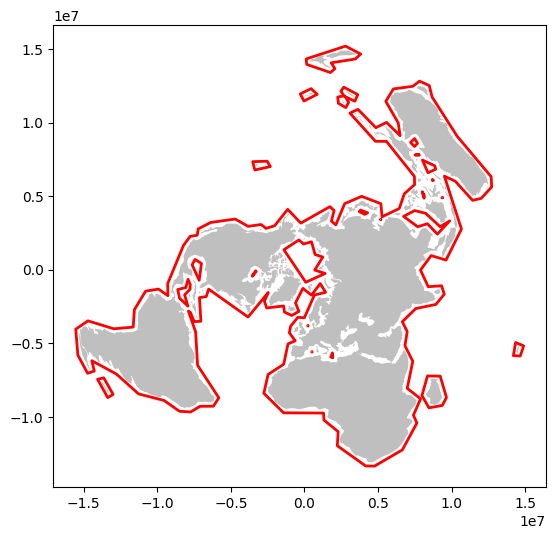

In [32]:
final_polygon_aeqd = final_polygon.to_crs(aeqd_na)

fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
final_polygon_aeqd.plot(ax=ax,
                   edgecolor='red',
                   facecolor='none',
                   alpha=1,
                   linewidth=2,
                   label='Rough Margin')
gdf_land_aeqd.plot(ax=ax, color='gray', alpha=0.5, label='Original Land')

plt.show()

# antimeridian stuff. not needed anymore

In [ ]:
import copy
import geopandas as gpd
import antimeridian
import matplotlib.pyplot as plt

# GeoSeries -> FeatureCollection
fc = final_polygon.__geo_interface__

# Fix antimeridian crossings
fixed_fc = antimeridian.fix_geojson(copy.deepcopy(fc), force_south_pole=True)

# FeatureCollection -> GeoDataFrame
fixed_gdf = gpd.GeoDataFrame.from_features(
    fixed_fc["features"],
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot fixed rough margin
fixed_gdf.plot(
    ax=ax,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    label="Rough Margin (antimeridian-fixed)"
)

# Plot original land
gdf_land.plot(
    ax=ax,
    color="gray",
    alpha=0.5,
    label="Original Land"
)

ax.set_title("Shoreline with 150km Rough Buffer (Antimeridian Safe)")
plt.show()


тоже вроде работает. сдвиг, объединение, потом обратно сдвиг

In [37]:
from shapely.ops import transform

def shift_lon(geom, shift):
    return transform(lambda x, y, z=None: (x + shift, y), geom)
from shapely.ops import unary_union
import shapely

def merge_antimeridian(geoms):
    """
    geoms: GeoSeries в EPSG:4326
    """
    # Чиним возможную невалидность после simplify
    geoms = geoms.apply(lambda g: g.buffer(0))

    # Сдвигаем геометрию так, чтобы антимеридиана не было
    shifted = geoms.apply(lambda g: shift_lon(g, 360))

    # Объединяем — КЛЮЧЕВОЙ МОМЕНТ
    merged = unary_union(shifted)

    # Возвращаем обратно
    unshifted = shift_lon(merged, -360)

    return unshifted


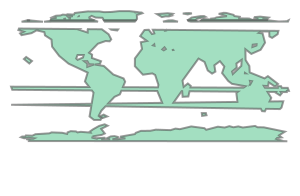

In [149]:
final_polygon = rough_polygon.to_crs(epsg=4326)

final_merged = merge_antimeridian(final_polygon)
final_merged

In [150]:
type(final_merged)

shapely.geometry.multipolygon.MultiPolygon

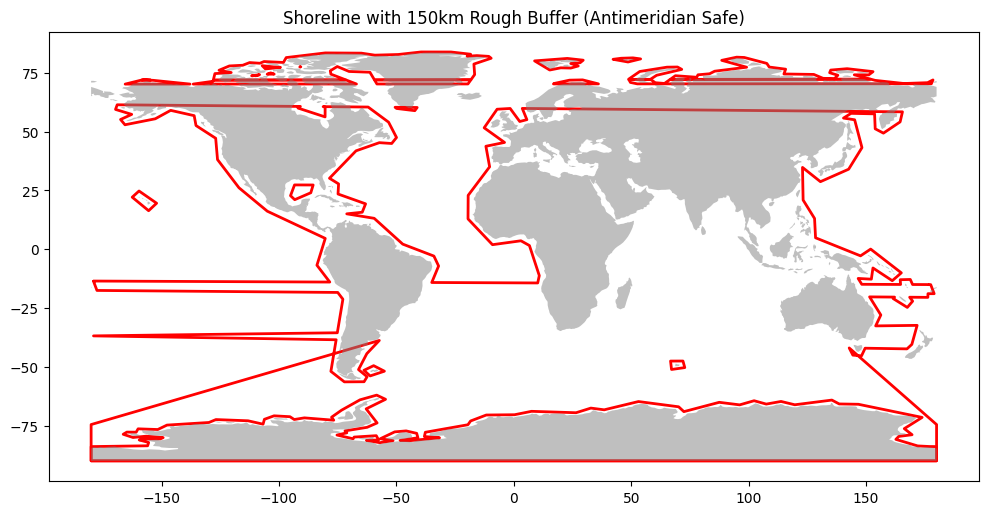

In [160]:
import copy
import geopandas as gpd
import antimeridian
import matplotlib.pyplot as plt

# Extract raw geometry (MultiPolygon)
geom = final_merged.__geo_interface__

# Wrap geometry as a FeatureCollection
fc = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": geom
        }
    ]
}

# Fix antimeridian crossings
fixed_fc = antimeridian.fix_geojson(copy.deepcopy(fc), force_south_pole=True)

# Back to GeoDataFrame
fixed_gdf = gpd.GeoDataFrame.from_features(
    fixed_fc["features"],
    crs="EPSG:4326"
)


fig, ax = plt.subplots(figsize=(12, 6))

# Plot fixed rough margin
fixed_gdf.plot(
    ax=ax,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    label="Rough Margin (antimeridian-fixed)"
)

# Plot original land
gdf_land.plot(
    ax=ax,
    color="gray",
    alpha=0.5,
    label="Original Land"
)

ax.set_title("Shoreline with 150km Rough Buffer (Antimeridian Safe)")
plt.show()


ocean testing

In [209]:
world_box = box(-180, -90, 180, 90)

land_shape = box(150, -10, 180, 10)
ocean_polygon = world_box.difference(land_shape)
gdf_ocean = gpd.GeoDataFrame(geometry=[ocean_polygon], crs="EPSG:4326")

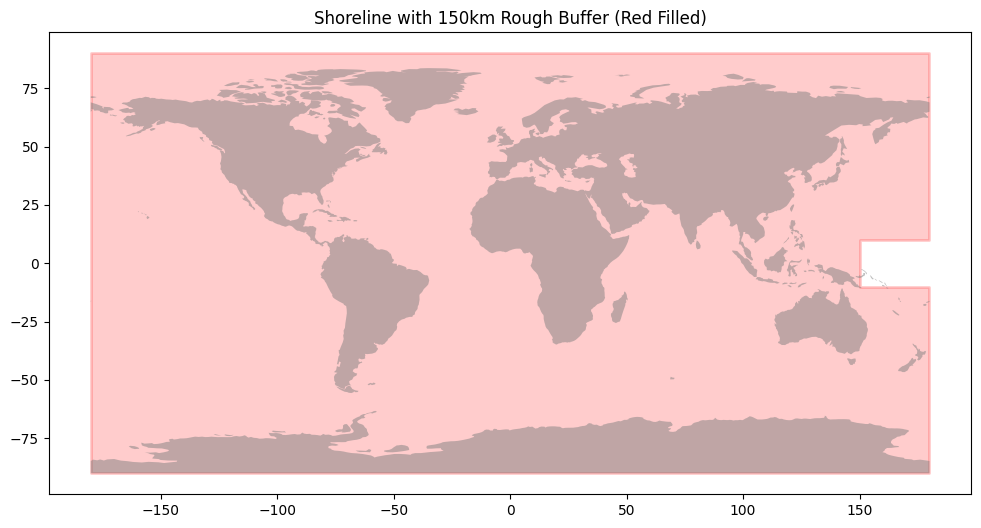

In [210]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
gdf_ocean.plot(ax=ax,
                   edgecolor='red',
                   facecolor='red',
                   alpha=0.2,
                   linewidth=2,
                   label='Rough Margin')
gdf_land.plot(ax=ax, color='gray', alpha=0.5, label='Original Land')
ax.set_title("Shoreline with 150km Rough Buffer (Red Filled)")
plt.show()